Part 1 of this question is "what is the conceptual difference between nodes and entities?"
Part 2 of this questions "why are entities sometimes repeated twice in the nodes file?"

The output files in question are create_final_entities.parquet and create_final_nodes.parquet (create_final_relationships.parquet is also related).

GraphRAG extracts entities and relationships from text content and generates a graph. This graph is then used as the entry point for algorithms to summarize and answer questions about your dataset. When we extract entities, we create a canonical list of entities including the text units they were found within. This entity data is saved to create_final_entities.parquet.

We then combine the entities table and the relationships table to create a graph (network). Once we put each entity into the graph, it becomes a node in that graph (and the relationships are edges), and thus adopts new semantic meaning and analytic properties. You'll notice, for example, that in the nodes table each entity has a degree, x, y, and size. Degree is the node degree (connectedness), and x and y can be populated with a position in 2D coordinate space for visualizing the graph (see the configs for Node2Vec embeddings and UMAP). We use the degree to represent the size by default, so those columns are equivalent (but you could use any measure you deem important to set the size of a node in a graph visualization...).

As for the duplication: one of the graph analysis steps we run is hierarchical community detection with Leiden. A community will be assigned for every node, at every level in the hierarchy (unless that node becomes too distinct and becomes "orphaned" at some depth). This results in a duplicate entry in the nodes table for each computed community level. So the create_final_nodes.parquet is a one-to-many from create_final_entities.parquet, using the id field as join key.

To summarize: entities are canonical, nodes are a representation of that entity in graph space, and duplication is because we compute hierarchical communities and add an entry for each in the nodes table.

In [2]:
import pandas as pd


In [3]:
output_path = "/home/cip/ce/ix05ogym/Majid/LLM/GraphRag/elec_graph/output/"
final_node = pd.read_parquet(output_path+'create_final_nodes.parquet')
final_node.sort_values('degree',ascending=False)

,level,title,type,description,source_id,degree,human_readable_id,id,graph_embedding,community,size,entity_type,top_level_node_id,x,y
756,1,SOLDERING,PROCESS,Soldering is a process that joins metal parts ...,"18d2f00a43c62b2939f772bea9e7efb2,304221396fe58...",120,13,e40202c25c814fb2bea97dd008d6bce7,"[0.05933641269803047, 0.0006442164885811508, -...",13,120.0,None,e40202c25c814fb2bea97dd008d6bce7,-2.106249,-5.453313
1499,2,SOLDERING,PROCESS,Soldering is a process that joins metal parts ...,"18d2f00a43c62b2939f772bea9e7efb2,304221396fe58...",120,13,e40202c25c814fb2bea97dd008d6bce7,"[0.04815356805920601, 0.01916142739355564, -0....",58,120.0,None,e40202c25c814fb2bea97dd008d6bce7,-2.106249,-5.453313
13,0,SOLDERING,PROCESS,Soldering is a process that joins metal parts ...,"18d2f00a43c62b2939f772bea9e7efb2,304221396fe58...",120,13,e40202c25c814fb2bea97dd008d6bce7,"[0.09325306117534637, -0.01446319930255413, -0...",0,120.0,None,e40202c25c814fb2bea97dd008d6bce7,-2.106249,-5.453313
12,0,PRINTED CIRCUIT BOARD,TECHNOLOGY,"A printed circuit board (PCB) is a flat, rigid...","0933f88d289fe0ff6b43afa7c799fe47,21d4e84567dbf...",44,12,3bfa928fa72346a9bd36df9d18e29d46,"[0.09306538105010986, 0.00817212462425232, 0.0...",1,44.0,None,3bfa928fa72346a9bd36df9d18e29d46,1.706307,9.736855
755,1,PRINTED CIRCUIT BOARD,TECHNOLOGY,"A printed circuit board (PCB) is a flat, rigid...","0933f88d289fe0ff6b43afa7c799fe47,21d4e84567dbf...",44,12,3bfa928fa72346a9bd36df9d18e29d46,"[0.08200949430465698, -0.033320315182209015, 0...",28,44.0,None,3bfa928fa72346a9bd36df9d18e29d46,1.706307,9.736855
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
617,0,DEFECT,EVENT,A defect is a flaw or imperfection in a produc...,726de752d56f7dd324374d2377982042,0,575,074237813d5643fe92542fdada9966f2,None,None,NaN,None,074237813d5643fe92542fdada9966f2,NaN,NaN
853,1,WORLDWIDE ADDRESSES,DOCUMENT,Worldwide addresses is a list of addresses of ...,e79b884d7685eec5915f598876065fa0,0,108,47a8aeed32e742719d74a1800ad2249d,None,None,NaN,None,47a8aeed32e742719d74a1800ad2249d,NaN,NaN
854,1,APPENDIX 1,DOCUMENT,Appendix 1 is a section of the book that provi...,e79b884d7685eec5915f598876065fa0,0,109,72a29d7bbe724b83a3629d216c4bbbc5,None,None,NaN,None,72a29d7bbe724b83a3629d216c4bbbc5,NaN,NaN
855,1,WHY NOT BLAME THE MACHINE?,CONCEPT,Why not blame the machine? is a question about...,e79b884d7685eec5915f598876065fa0,0,110,8d631b1fc3b149dca0877a9a52064665,None,None,NaN,None,8d631b1fc3b149dca0877a9a52064665,NaN,NaN


In [7]:
pd.set_option('display.max_rows', 10)


In [8]:
final_entities = pd.read_parquet(output_path+'create_final_entities.parquet')
types = final_entities['type'].value_counts()
types

type
MATERIAL    95
CONCEPT     79
PROCESS     72
OBJECT      69
EVENT       42
            ..
BEING        1
ENTITY       1
AMOUNT       1
VALUE        1
POWER        1
Name: count, Length: 74, dtype: int64

In [ ]:
final_relationships = pd.read_parquet(output_path+'create_final_relationships.parquet')
final_relationships

In [ ]:
final_relationships.sort_values('weight',ascending=False)


In [17]:
be = pd.read_parquet(output_path+'create_base_entity_graph.parquet')
be

,level,clustered_graph,embeddings
0,0,"<graphml xmlns=""http://graphml.graphdrawing.or...",{'186 SC SOLDERING PROCESSES': [-0.10285617411...
1,1,"<graphml xmlns=""http://graphml.graphdrawing.or...",{'186 SC SOLDERING PROCESSES': [-0.09738020598...
2,2,"<graphml xmlns=""http://graphml.graphdrawing.or...",{'186 SC SOLDERING PROCESSES': [-0.15194752812...


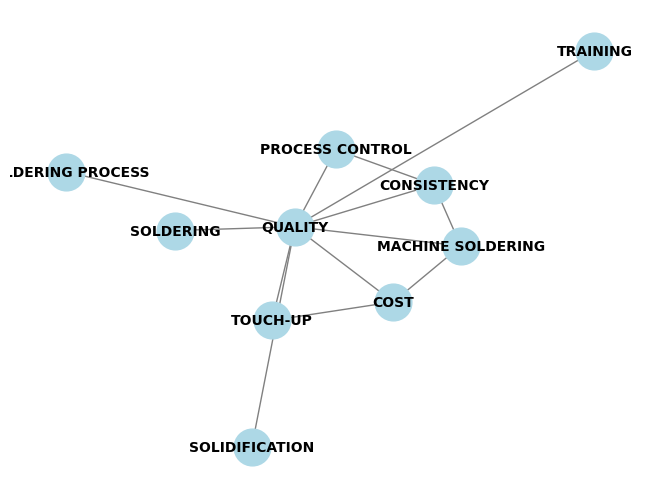

In [48]:
import networkx as nx

#graph = nx.read_graphml(output_path+'clustered_graph.0.graphml')

def get_subgraph_with_descendants(graph, node):
    # Get all descendants of the node (DFS)
    #descendants = list(nx.descendants(graph, node))  # Returns all descendants of the node
    #descendants = list(nx.bfs_successors(graph,'QUALITY',1))
    
    #descendants = descendants[0][1]
    descendants = list(nx.ego_graph(graph,node,1))
    # Include the original node
    descendants.append(node)
    
    # Create the subgraph from the descendants
    subgraph = graph.subgraph(descendants)
    
    return subgraph

subgraph = get_subgraph_with_descendants(g, 'QUALITY')

pos = nx.spring_layout(subgraph)
nx.draw(subgraph, pos, with_labels=True, node_size=700, node_color='lightblue', font_size=10, font_weight='bold', edge_color='gray')


In [34]:
descendants = list(nx.bfs_successors(graph,'QUALITY',1))
descendants[0][1]

['SOLDERING',
 'SOLIDIFICATION',
 'SOLDERING PROCESS',
 'COST',
 'CONSISTENCY',
 'TRAINING',
 'MACHINE SOLDERING',
 'TOUCH-UP',
 'PROCESS CONTROL']

In [51]:
path = nx.shortest_path(graph, source='ADDRESSES', target='ALLOY',)
for i in range(len(path) - 1):
    u = path[i]
    v = path[i + 1]
    description = graph[u][v]['description']
    print(f"{u} -> {v}: {description}")

ADDRESSES -> ORGANIZATIONS: Addresses are used to identify the locations of organizations
ORGANIZATIONS -> STANDARDS: Organizations are responsible for developing and publishing standards
STANDARDS -> SOLDERING: Standards are used to define the requirements for soldering, such as the types of solder that can be used, the temperature of the soldering iron, and the cleanliness of the surfaces being soldered
SOLDERING -> SOLDER: Soldering is a process that uses solder to join metal parts together. Solder is the material used in soldering to join metal parts together. Soldering involves melting and flowing solder into the joint between two metal parts. 

SOLDER -> ALLOY: Solder is an alloy, typically made of tin and lead, used to join metals together


In [47]:
g = nx.read_graphml(output_path+'summarized_graph.graphml')
g